# Explanability for widedeep

This notebook shows how to explain [widedeep models](https://github.com/jrzaurin/pytorch-widedeep). [Click here to open in Google Colab](https://colab.research.google.com/github/rajshah4/widedeep_notebooks/blob/main/Explainability_WideDeep.ipynb).   
  
  
To start with, there are two datasets in this notebook.  Adult is larger, but much slower to run. The Friedman synthetic dataset is a regression problem that runs quickly. 
The notebook then moves on to show a variety of explanation methods from the Captum and Shap packages. 

In [ ]:
##Packages to install when using Google Colab
#!pip install pytorch-widedeep
#!pip install captum
#!pip install shap
##Restart runtime after you have installed all the packages
##Some explainers need instances with High-RAM

In [1]:
import numpy as np
import pandas as pd
import torch

from torch.utils.data.dataloader import DataLoader

import pytorch_widedeep
from pytorch_widedeep.training._wd_dataset import WideDeepDataset
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.training import Trainer
from pytorch_widedeep.models import Wide, TabMlp, TabResnet, TabTransformer, WideDeep, TabFastFormer, TabPerceiver, SAINT
from pytorch_widedeep.metrics import Accuracy, Precision
from pytorch_widedeep.losses import RMSELoss

from captum.attr._core.feature_permutation import FeaturePermutation
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation, DeepLiftShap, Saliency, ShapleyValueSampling

import shap

from sklearn.model_selection import train_test_split

/Users/rajiv.shah/anaconda3/envs/pytorch/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/rajiv.shah/anaconda3/envs/pytorch/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/rajiv.shah/anaconda3/envs/pytorch/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/rajiv.shah/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is 

## Datasets

### Use Adult dataset
This is a classification problem.  Also, with the categoricals, some of the explainability methods will not work well with categoricals.

In [2]:
## This takes longer to run and contains many categorical features
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                 'capital_gain', 'capital_loss', 'hours_per_week', 
                 'native_country', 'income']

df = pd.read_csv('adult.data', header=None, names=names, na_values=['?', ' ?'])
#create a binary target
df['income_label'] = (df["income"].apply(lambda x: ">50K" in x)).astype(int)
df.drop('income', axis=1, inplace=True)


cat_embed_cols = [('education',16), ('relationship',8), ('workclass',16), ('occupation',16),('native_country',16)]
cat_embed_cols = ['education', 'relationship' , 'workclass' , 'occupation' , 'native_country']
continuous_cols = ['age','hours_per_week']
target_col = 'income_label'
target = df[target_col].values
original_df = df
original_df.head()

--2021-10-02 19:18:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  4.40MB/s    in 0.9s    

2021-10-02 19:18:29 (4.40 MB/s) - ‘adult.data’ saved [3974305/3974305]



,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


### Build Friedman synthetic dataset

This is regression dataset.  The first five features are the signal, the rest are random.  I also included code to include on categorical feature.

In [3]:
import sklearn.datasets as dt
x,y = dt.make_friedman1(n_features=10,n_samples=10000,random_state=123,noise=.1)
df = pd.DataFrame(x)
df.columns = ["0","1","2","3","4","5","6","7","8","9"]
labels = ["A","B","C"]
df['9'] = pd.qcut(df['9'],
                        q=[0, .3, .6, 1],
                        labels=labels)

continuous_cols = ["0","1","2","3","4","5","6","7","8"]
cat_embed_cols = [('9',4)]
cat_embed_cols = ['9']
target = y[0:5000]
original_df = df.head(5000)
original_df 

,0,1,2,3,4,5,6,7,8,9
0,0.696469,0.286139,0.226851,0.551315,0.719469,0.423106,0.980764,0.684830,0.480932,B
1,0.343178,0.729050,0.438572,0.059678,0.398044,0.737995,0.182492,0.175452,0.531551,B
2,0.634401,0.849432,0.724455,0.611024,0.722443,0.322959,0.361789,0.228263,0.293714,C
3,0.092105,0.433701,0.430863,0.493685,0.425830,0.312261,0.426351,0.893389,0.944160,B
4,0.623953,0.115618,0.317285,0.414826,0.866309,0.250455,0.483034,0.985560,0.519485,C
...,...,...,...,...,...,...,...,...,...,...
4995,0.361680,0.462336,0.339134,0.005487,0.010772,0.031931,0.869185,0.368284,0.952957,C
4996,0.949139,0.742035,0.101951,0.592215,0.890264,0.939644,0.193173,0.271061,0.450948,B
4997,0.696972,0.438785,0.118629,0.467978,0.908098,0.043994,0.763559,0.419309,0.981723,B
4998,0.312900,0.765379,0.222519,0.715873,0.891121,0.143177,0.939213,0.857522,0.897418,B


## Train a FastFormer Model 

In [4]:
#Split the dataset for training
df_train, df_test,y_train,y_test = train_test_split(original_df, target, test_size=0.2,random_state=42)

In [5]:
# prepare and fit
# by default I use the TabFastFormer, but the code is here if you want to try another tabular model instead

tab_preprocessor = TabPreprocessor(
    continuous_cols=continuous_cols, embed_cols=cat_embed_cols,
    for_transformer=True, 
    with_cls_token=True
)
X_tab_train = tab_preprocessor.fit_transform(df_train)

tabfastformer = TabFastFormer(
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=tab_preprocessor.continuous_cols,
    embed_input=tab_preprocessor.embeddings_input,
    n_blocks=2,
    n_heads=4,
)

_ = TabTransformer(column_idx=tab_preprocessor.column_idx,
                                 embed_input=tab_preprocessor.embeddings_input,
                                 continuous_cols=tab_preprocessor.continuous_cols, 
                                 cont_norm_layer="batchnorm", 
                                 n_blocks=4, n_heads=4 
                                )

_ = SAINT(column_idx=tab_preprocessor.column_idx,
              embed_input=tab_preprocessor.embeddings_input,
              continuous_cols=tab_preprocessor.continuous_cols, 
              transformer_activation="geglu",
              n_blocks=2, n_heads=4, 
             )

model = WideDeep(deeptabular=tabfastformer)
trainer = Trainer(model, objective="rmse")
#trainer = Trainer(model, objective="binary") #use this for the adult dataset
trainer.fit(
    X_tab=X_tab_train, target=y_train, n_epochs=10, batch_size=256, val_split=0.2
)

valid: 100%|██████████| 4/4 [00:00<00:00, 28.01it/s, loss=1.51]


In [6]:
## Prepare the test set for captum/shap

# transform the test set: this is just a numpy array
X_tab_test = tab_preprocessor.transform(df_test)
# wrap it up with a pytorch Dataloader or simply as a tensor:
X_tab_test = torch.from_numpy(X_tab_test)
y_tab_test = torch.from_numpy(y_test)

# note that the WideDeepDataset class is now a private module in the pytorch-widedeep package.
# from pytorch_widedeep.training._wd_dataset import WideDeepDataset
# This is because initially it was designed only for internal purposes. Javier tells me that 
# if needed it will be made public and available as any other import.
test_loader_captum = DataLoader(
    dataset=WideDeepDataset(X_tab=X_tab_test, target=y_tab_test),
    batch_size=100,
    num_workers=8,
    shuffle=False,
)

X_te, y_te = next(iter(test_loader_captum))

## Captum Permutation based Feature Importance

In [7]:
feature_perm = FeaturePermutation(model.deeptabular.eval())
attr_fic = feature_perm.attribute(X_tab_test,target=0)  ##It's fast, so ran it across the entire test set
attr_fic.shape

torch.Size([1000, 11])

In [8]:
#sum up attributions
attr_fic_sum = torch.div(torch.sum((np.absolute(attr_fic)),0),len(attr_fic))

# start from 1 since the first attribute is the `CLS` token column. This is the result of how 
# pytorch-widedeep prepares the data, where the `CLS` token column is added as the first column
# of the dataset. This is because pytorch-widedeep offers a series of possibilities as to how
# the embeddings will be processed and "pooled" once they have gone through the transformer 
# blocks. With that in mind it is easier to add the `CLS` token earlier, after preprocessing
# than on the fly in the forward pass
attr_fic_sum[1:]

tensor([0.0718, 2.3363, 2.3392, 1.4097, 3.3156, 1.6375, 0.0801, 0.1071, 0.1496,
        0.0766])

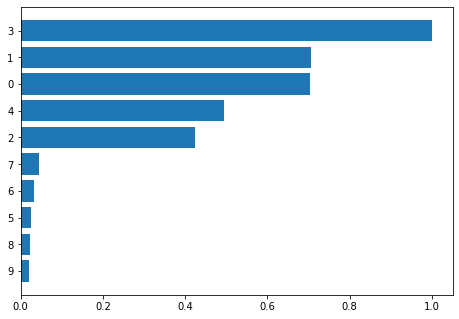

In [9]:
#munge feature importance for viz
df = pd.DataFrame(attr_fic_sum[1:])
df.index = {k:v for k,v in tab_preprocessor.column_idx.items() if k != "cls_token"}
df = df/df.max()
df.columns =["feature"]
df = df.sort_values(by=['feature'])
y_pos = np.arange(len(df))

#Viz plot
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = df.index
students = df['feature']

ax.barh(langs,students,align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df.index)
#ax.invert_yaxis()
plt.show()

## Shap Feature Importance

In [10]:
##Background:
background = X_tab_train[0:100]  ##Background sample - larger is better, but takes longer

In [11]:
#GradientExplainer uses the integrated gradients method
explainer = shap.GradientExplainer(model.deeptabular.eval(), torch.Tensor(background))
shap_values_gradient = explainer.shap_values(X_tab_test)  #was X_te["deeptabular"] if you want batch
print (shap_values_gradient.shape)
shap_values_gradient[0:3]

(1000, 11)


array([[ 0.        ,  0.        ,  1.71816921,  1.76691716, -1.93479669,
         2.41401004, -2.35346451, -0.07881207, -0.04693323, -0.17676018,
        -0.02497393],
       [ 0.        ,  0.        ,  1.16666423,  0.6276194 , -0.73971874,
         2.63397861,  1.2296752 , -0.10156326, -0.03927391, -0.16706112,
        -0.01441024],
       [ 0.        ,  0.        ,  1.24107081,  1.20310461,  1.62692691,
         1.21661734, -2.64588204,  0.10280799, -0.11623774, -0.07936699,
        -0.01284655]])

In [12]:
# DeepExplainer is an enhanced version of the DeepLIFT algorithm
explainer = shap.DeepExplainer(model.deeptabular.eval(), torch.Tensor(background))
shap_values = explainer.shap_values(X_tab_test) 
print (shap_values.shape)
shap_values[0:3]
##Index 0 - Feature 9 has all 0 when doing Friedman ##

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(1000, 11)


array([[ 0.        ,  0.        ,  2.00821109,  4.3065835 , -1.84452905,
         1.42808412, -2.0948907 , -0.06920522,  0.14392952, -0.31143169,
        -0.29054899],
       [ 0.        ,  0.        ,  1.12161393,  1.28003389, -1.92373635,
         1.87077931,  0.97330264, -0.11847295,  0.07997074, -0.30871469,
        -0.08682139],
       [ 0.        ,  0.        ,  1.61535089,  2.14600638, -1.47994548,
         0.63161335, -2.09077872, -0.26707955,  0.15815406, -0.4080312 ,
        -0.0668824 ]])

In [13]:
fnl = tab_preprocessor.column_idx

In [14]:
#examine one row
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[1], list(fnl.keys()))

`np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


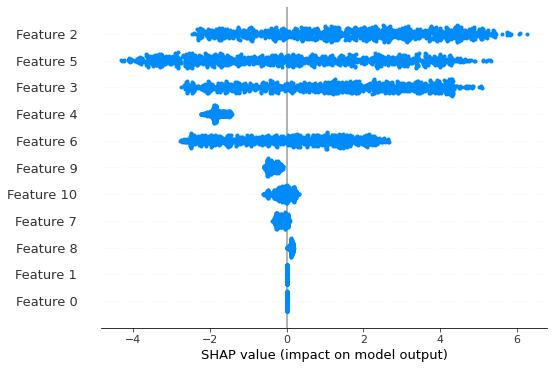

In [15]:
#get global feature impact
shap.summary_plot(shap_values)

In [16]:
# Get force plot that groups explanations together
shap.force_plot(explainer.expected_value[0], shap_values, list(fnl.keys()))

## Other Captum Explainers
This section brings together a number of other explainers available in captum

In [17]:
ig = IntegratedGradients(model.deeptabular.eval())
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model.deeptabular.eval())
gs = GradientShap(model.deeptabular.eval())
fa = FeatureAblation(model.deeptabular.eval())
dls = DeepLiftShap(model.deeptabular.eval())
sal = Saliency(model.deeptabular.eval())
shapv = ShapleyValueSampling(model.deeptabular.eval())

In [18]:
ig_attr_test, delta = ig.attribute(X_tab_test, target=0, return_convergence_delta=True)
ig_attr_test = ig.attribute(X_tab_test, n_steps=50, target=0)
dl_attr_test = dl.attribute(X_tab_test,target=0)
gs_attr_test = gs.attribute(X_tab_test,torch.Tensor(background),target=0)
fa_attr_test = fa.attribute(X_tab_test,target=0)
dls_attr_test = dls.attribute(X_tab_test,torch.Tensor(background),target=0) ##Takes longer
sal_attr_test = sal.attribute(X_tab_test,target=0)
shapv_attr_test = shapv.attribute(X_tab_test,target=0)

Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


Feature Importance for IG
['cls_token', '9', '0', '1', '2', '3', '4', '5', '6', '7', '8']
cls_token :  0.000
9 :  0.000
0 :  1.846
1 :  1.835
2 :  2.060
3 :  2.244
4 :  1.176
5 :  0.114
6 :  0.147
7 :  0.255
8 :  0.084


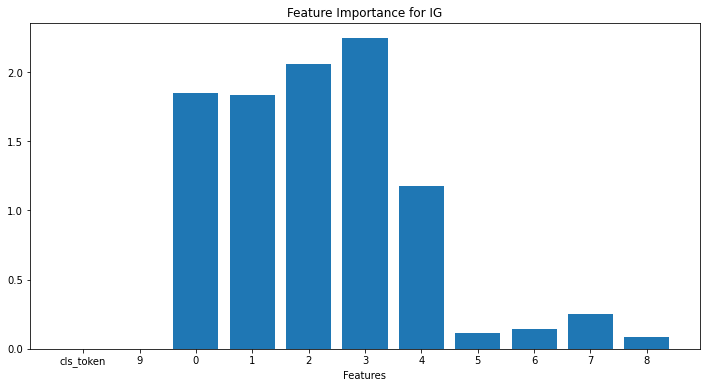

In [19]:
# Helper method to print importances and visualize distribution if you want to visualize one method
def visualize_importances(feature_names, importances, title="Feature Importance for IG", plot=True, axis_title="Features"):
    print(title)
    print (feature_names)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(list(fnl.keys()), np.mean(np.abs(sal_attr_test.detach().numpy()), axis=0)) 

## Summary Visualization of all Explanation Methods

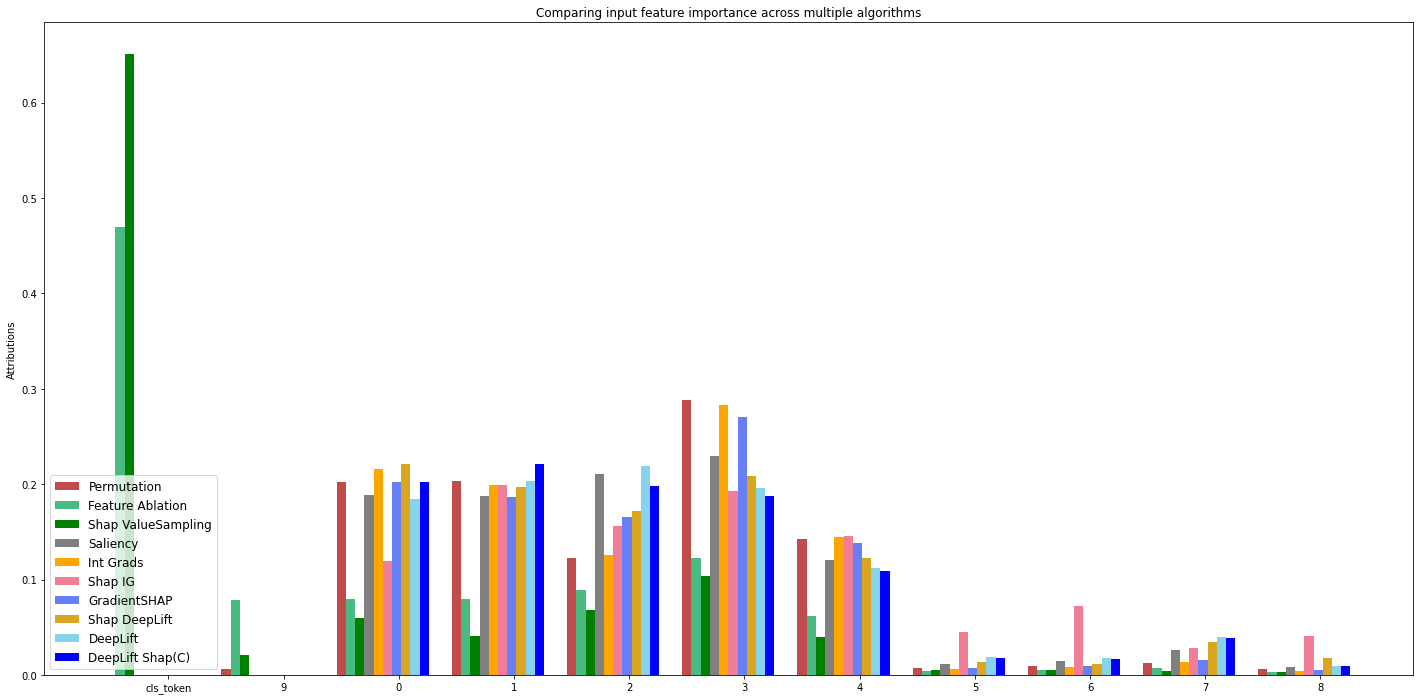

In [20]:
# prepare attributions for visualization
# From https://captum.ai/tutorials/House_Prices_Regression_Interpret
X_test = X_tab_test
fnl = tab_preprocessor.column_idx
x_axis_data_labels = fnl.keys()

x_axis_data = np.arange(X_test.shape[1])
#x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

fic_attr_test_sum = np.abs(attr_fic.detach().numpy()).sum(0)
fic_attr_test_norm_sum = fic_attr_test_sum / np.linalg.norm(fic_attr_test_sum, ord=1)

ig_attr_test_sum = np.abs(ig_attr_test.detach().numpy()).sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

dl_attr_test_sum = np.abs(dl_attr_test.detach().numpy()).sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = np.abs(gs_attr_test.detach().numpy()).sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = np.abs(fa_attr_test.detach().numpy()).sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

shap_attr_test_sum = np.abs(shap_values).sum(0)
shap_attr_test_norm_sum = shap_attr_test_sum / np.linalg.norm(shap_attr_test_sum, ord=1)

shap_attr_test_sum = np.abs(shap_values_gradient).sum(0)
shapg_attr_test_norm_sum = shap_attr_test_sum / np.linalg.norm(shap_attr_test_sum, ord=1)

dls_attr_test_sum = np.abs(dls_attr_test.detach().numpy()).sum(0)
dls_attr_test_norm_sum = dls_attr_test_sum / np.linalg.norm(dls_attr_test_sum, ord=1)

sal_attr_test_sum = np.abs(sal_attr_test.detach().numpy()).sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

shapv_attr_test_sum = np.abs(shapv_attr_test.detach().numpy()).sum(0)
shapv_attr_test_norm_sum = shapv_attr_test_sum / np.linalg.norm(shapv_attr_test_sum, ord=1)


width = 0.08
legends = ['Permutation', 'Feature Ablation', 'Shap ValueSampling', 'Saliency', 'Int Grads','Shap IG', 'GradientSHAP', 'Shap DeepLift','DeepLift','DeepLift Shap(C)']


plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importance across multiple algorithms')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, fic_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 2 * width, shapv_attr_test_norm_sum, width, align='center', alpha=1.0, color='green')

ax.bar(x_axis_data + 3 * width, sal_attr_test_norm_sum, width, align='center', alpha=1.0, color='grey')
ax.bar(x_axis_data + 4 * width, shapg_attr_test_norm_sum, width, align='center', alpha=1.0, color='orange')##
ax.bar(x_axis_data + 5 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + 6 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')

ax.bar(x_axis_data + 7 * width, shap_attr_test_norm_sum, width, align='center', alpha=1.0, color='goldenrod')
ax.bar(x_axis_data + 8 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')##
ax.bar(x_axis_data + 9 * width, dls_attr_test_norm_sum, width, align='center', alpha=1.0, color='blue')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()